# **Project Title**  
**Group Name:** *Pip Install ChatGPT*  
**Course:** Programming for Data Science (DS-1007)  
**Instructor:** *[Instructor Name]*  
**Submission Date:** *`12/04/2024`*  

---

## **Project Overview**

### **Objective**
Provide a brief description of the problem you're solving or the purpose of your project.

- **Goal 1:** *[Clearly state your goal, e.g., Analyze NYC taxi fare trends and their relationship with weather conditions.]*
- **Goal 2:** *[Secondary goal or sub-objective.]*

### **Data Sources**
- **Main Dataset:** NYC Yellow Taxi 2023 trips (*parquet format*).  
- **Secondary Dataset(s):** NYC Weather data (*csv format*), LocationID/NYC Map (*GDP data).  

---

## **Pipeline Overview**

### **Steps Taken**
1. **Data Collection and Merging**:
   - Merged all parquet files for NYC Yellow Taxi trips.
   - For Question 3 and Question 4, we integrate weather and geospatial data using `date`, `hour` and `LocationID` keys.
2. **Data Cleaning**:
   - Removed missing values.
   - Handled outliers using the IQR method.
3. **Exploratory Data Analysis**:
   - TBD
4. **Insights & Conclusions**:
   - *[Q1,Q2,Q3,Q4]*

---

## **Notebooks Structure**
1. **Preprocessing**:
   - Functions to clean, merge, and save the dataset for analysis.
   - Sampling and removing outliers.

2. **Analysis**:
   - Trends in fares and rides based on weather and temperature.
   - Pickup location analysis and heatmap visualizations.

3. **Visualizations**:
   - Time series plots for ride frequency.
   - Heatmaps for pickup

## Importing Libraries

To begin, we import all the necessary libraries for data analysis, visualization, and geospatial processing. 

This includes commonly used Python libraries like:
- `numpy`, `pandas`, and `matplotlib` for numerical and data manipulation, and basic plotting.
- `seaborn` for advanced visualizations, including custom hue plots.
- `geopandas` and `folium` for geospatial data processing and interactive map visualizations.

In addition to standard libraries, we also import project-specific functions:
- `visualize.py`: Contains reusable functions for custom plots.
- `preprocess.py`: Handles data merging and preprocessing tasks.
- `modeling.py`: Includes modeling utilities and advanced analytical workflows.

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import folium
import geopandas as gpd

# Importing functions from other scripts
from visualize import * # Importing reusable functions for all visualize plots
from preprocess import * # Importing functions for basic merging and preprocessing data
import os

In [2]:
# Importing nyc taxi data for 2023

# getting the current working directory
script_dir = os.getcwd()
data_dir = os.path.join(script_dir, "..", "data")  # Adjust path as needed
print("Script Directory:", script_dir)
print("Data Directory:", data_dir)

# Fuction for preprocessing to merge parquets
data = merge_parquets(data_dir)


Script Directory: /Users/alex/Documents/2. NYU/DS-1007 Programming for Data Science/Project/DS1007_FinalProject/code
Data Directory: /Users/alex/Documents/2. NYU/DS-1007 Programming for Data Science/Project/DS1007_FinalProject/code/../data
concatenating all yellow_tripdata parquets


## Sampling the Data
To optimize performance during the analysis, we sample 30% of the data. This reduces computational load while preserving representative data trends.

In [3]:
# Sampling data to get 30% of the data
sampled_data = sample_dat(data,0.3, 1)

## Integrating Weather Data
We integrate NYC weather data for 2023 with the sampled taxi data to enhance the analysis. This includes handling precipitation, temperature, and other relevant weather conditions.

In [4]:
weather_path = os.getcwd()
weather_data_dir = os.path.join(weather_path,'..','data','nyc_weather_2023.csv')

merged_data_dir = os.path.join(data_dir,"merged_data.parquet")
print("Weather Data Directory:", weather_data_dir)
print("Merged Data Directory:", merged_data_dir)

# Merging Taxi data with weather data
merged_data = merge_with_weather(sampled_data, weather_data_dir, merged_data_dir )


Weather Data Directory: /Users/alex/Documents/2. NYU/DS-1007 Programming for Data Science/Project/DS1007_FinalProject/code/../data/nyc_weather_2023.csv
Merged Data Directory: /Users/alex/Documents/2. NYU/DS-1007 Programming for Data Science/Project/DS1007_FinalProject/code/../data/merged_data.parquet


/Users/alex/Documents/2. NYU/DS-1007 Programming for Data Science/Project/DS1007_FinalProject/code/preprocess.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_data['date'] = main_data['tpep_pickup_datetime'].dt.date
/Users/alex/Documents/2. NYU/DS-1007 Programming for Data Science/Project/DS1007_FinalProject/code/preprocess.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_data['hour'] = main_data['tpep_pickup_datetime'].dt.hour


## Converting Weather Data to Categorical Values
To facilitate analysis, we convert weather data (e.g., precipitation) into categorical variables. For instance, precipitation is categorized into `Precipitation` or `No Precipitation (Clear)` based on thresholds.

In [5]:
def categorize_weather(data, column_name, threshold=0):
    """
    Categorizes weather conditions based on precipitation values.

    Parameters:
    ----------
    data : pd.DataFrame
        DataFrame containing weather data.
    column_name : str
        Column name for precipitation data.
    threshold : float, optional
        Precipitation threshold to distinguish between categories (default is 0).

    Returns:
    -------
    pd.Series
        Categorical weather conditions.
    """
    return np.where(data[column_name] > threshold, "Precipitation", "No Precipitation (Clear)")

# Example Usage
merged_data['weather_category'] = categorize_weather(merged_data, 'precipitation (mm)')
print(merged_data['weather_category'].value_counts())

weather_category
No Precipitation (Clear)    9554579
Precipitation               1823597
Name: count, dtype: int64


In [6]:
# Group by weather category and calculate ride frequency and average fare
weather_analysis = merged_data.groupby('weather_category').agg({
    'tpep_pickup_datetime': 'count',  # Ride frequency
    'fare_amount': ['mean', 'sum'],  # Average and total fares
}).reset_index()

# Rename columns for clarity
weather_analysis.columns = ['weather_category', 'ride_count', 'avg_fare', 'total_fare']

print(weather_analysis)

           weather_category  ride_count   avg_fare    total_fare
0  No Precipitation (Clear)     9554579  19.900633  1.901422e+08
1             Precipitation     1823597  19.955999  3.639170e+07


## Ride Frequency by Weather Condition

This section examines the distribution of ride frequency across weather conditions (precipitation vs. no precipitation). 
We first analyze the raw counts of rides under each weather category, followed by normalized ride counts per hour for a fair comparison.

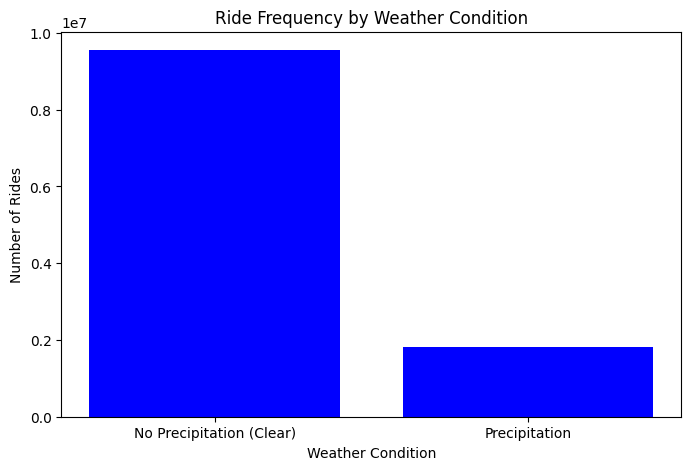

In [7]:
# Plotting Ride Frequency
plot_bar(
    data=weather_analysis,
    x='weather_category',
    y='ride_count',
    title='Ride Frequency by Weather Condition',
    xlabel='Weather Condition',
    ylabel='Number of Rides'
)

### Insights: Raw Ride Counts
- **Significant disparity in raw ride counts**: Clear weather has a much higher total ride count compared to precipitation days.
- This disparity reflects the higher occurrence of clear weather days, which naturally allows for more rides.
- Solely analyzing raw counts can **bias interpretations**, as precipitation days are underrepresented in the dataset.

## Normalization by Weather Hours

To address the bias caused by the disproportionate occurrence of clear weather days, we normalize the ride frequency by the total number of hours under each weather condition.
This allows us to compare ride frequencies across conditions more accurately.

In [8]:
# Normalize by number of weather condition hours
weather_occurrences = merged_data.groupby('weather_category')['time'].nunique().reset_index(name='weather_hours')

# Merge with weather_analysis
weather_analysis = weather_analysis.merge(weather_occurrences, on='weather_category')
# Calculating avg rides per hour

weather_analysis['rides_per_hour'] = weather_analysis['ride_count'] / weather_analysis['weather_hours']

print(weather_analysis)

           weather_category  ride_count   avg_fare    total_fare  \
0  No Precipitation (Clear)     9554579  19.900633  1.901422e+08   
1             Precipitation     1823597  19.955999  3.639170e+07   

   weather_hours  rides_per_hour  
0           7405     1290.287508  
1           1354     1346.822009  


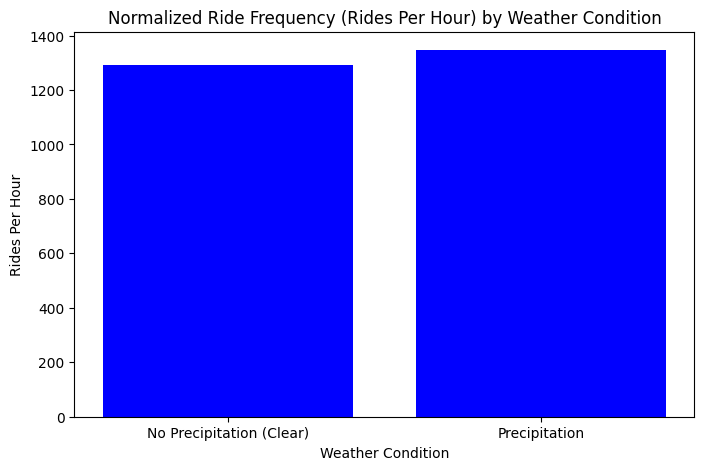

In [21]:
# Plotting Average Rides per Hours (normalized)
plot_bar(
    data=weather_analysis,
    x='weather_category',
    y='rides_per_hour',
    title='Normalized Ride Frequency (Rides Per Hour) by Weather Condition',
    xlabel='Weather Condition',
    ylabel='Rides Per Hour'
)

### Insights: Normalized Rides Per Hour
- After normalization, ride frequencies during **clear and rainy conditions are very similar**.
- This indicates that demand for rides is **relatively stable** irrespective of weather conditions.
- The previously observed disparity in absolute counts was primarily driven by the higher number of clear weather hours.
- **Key takeaway:** Weather conditions (precipitation vs no precipitation) do not seem to heavily influence overall ride demand per hour.

## Transition to Daily Analysis
To analyze ride behavior more accurately across weather conditions, we use normalized daily data. By dividing the total rides by the number of weather hours for each condition, this approach eliminates biases caused by the disproportionate number of clear weather hours.


## Normalizing Daily Data

To account for the unequal distribution of hours across weather conditions, we calculate the normalized rides per hour. 
This ensures a consistent basis for comparison and highlights the true demand patterns across clear and rainy days.

Steps:
- **Aggregate Data:** Group rides by `date` and `weather_category`.
- **Normalize Rides:** Divide the total rides by the total hours for each weather condition to compute rides per hour.

In [10]:
# Group by date and weather category
daily_weather = merged_data.groupby(['date', 'weather_category']).agg({
    'tpep_pickup_datetime': 'count',  # Ride count
    'time': 'nunique'  # Number of weather hours in a day
}).reset_index()

# Ensure the date column is in datetime format
daily_weather['date'] = pd.to_datetime(daily_weather['date'])

# Normalize rides per weather hour
daily_weather['rides_per_hour'] = daily_weather['tpep_pickup_datetime'] / daily_weather['time']

print(daily_weather.head())

        date          weather_category  tpep_pickup_datetime  time  \
0 2023-01-01  No Precipitation (Clear)                 15485    17   
1 2023-01-01             Precipitation                  7276     7   
2 2023-01-02  No Precipitation (Clear)                 18628    23   
3 2023-01-02             Precipitation                   810     1   
4 2023-01-03  No Precipitation (Clear)                 13914    15   

   rides_per_hour  
0      910.882353  
1     1039.428571  
2      809.913043  
3      810.000000  
4      927.600000  


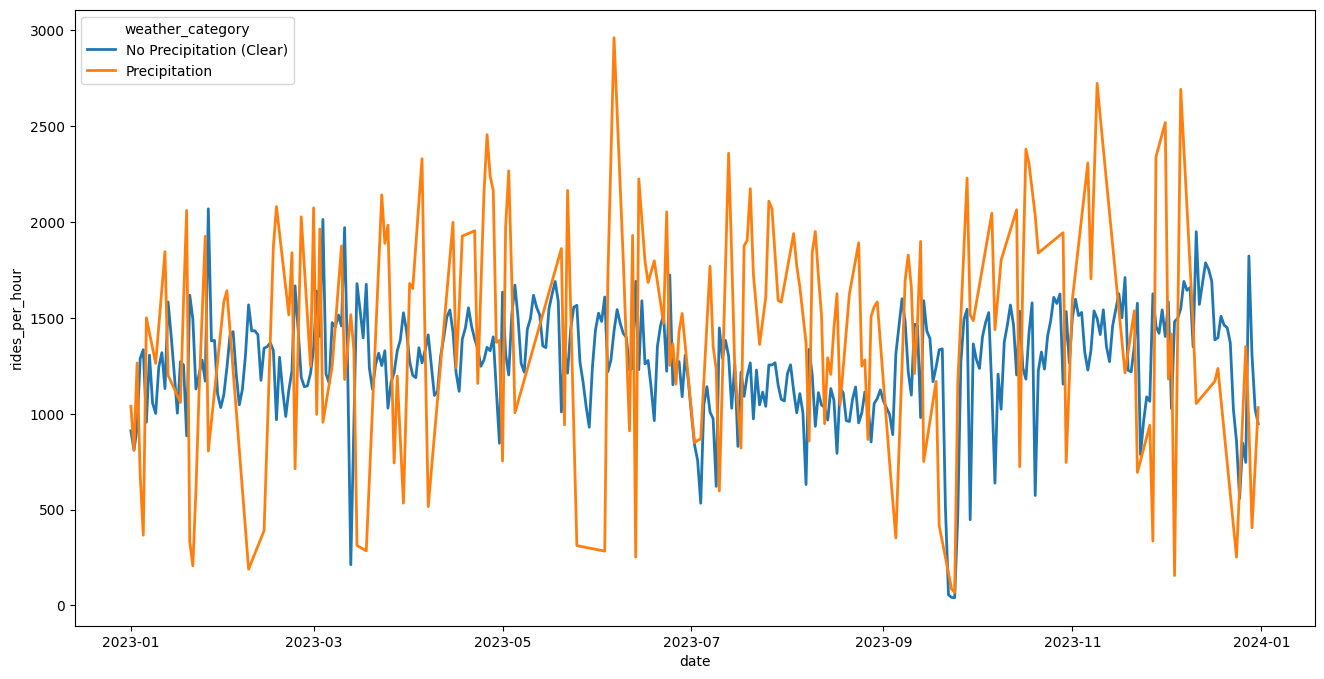

In [11]:
lineplot(
    x='date',
    y='rides_per_hour',
    title='Daily Rides Per Hour by Weather Condition',
    xlabel='Date',
    ylabel='Rides Per Hour',
    use_seaborn=True,
    data=daily_weather,
    hue='weather_category',
)

**Insights - Daily Analysis:**
- The data demonstrates that rides per hour show greater variability on days with precipitation, suggesting a less predictable demand pattern during rainy weather.
- On average, days with precipitation often exhibit higher rides per hour compared to clear weather days. This likely reflects increased dependency on ride services during bad weather when alternative modes of transportation may be less convenient or accessible.
- Significant spikes in rides per hour are observed on certain precipitation days, likely driven by extreme weather events or localized increases in demand. These peaks warrant further exploration to understand their drivers.

## Insights - Normalized Data

- **Increased Variability on Rainy Days:**
   - Days with precipitation exhibit **greater variability** in rides per hour compared to clear weather days.
   - This suggests that rainy weather might create more fluctuating demand patterns.

- **Peaks in Rainy Weather:**
   - On certain rainy days, significant spikes in rides per hour are observed. These spikes may result from extreme weather events or sudden increases in demand.


## Calculating Average Fare Per Ride

- **Normalize Rides:** Similarly, divide the `fare amount` by the `pickup count` for each weather condition to compute average daily fare per ride in different weather conditions.

In [12]:
# Group by date and weather condition
avg_price_per_ride = merged_data.groupby(['date', 'weather_category']).agg({
    'fare_amount': 'sum',  # Total fare for the day
    'tpep_pickup_datetime': 'count'  # Total rides for the day
}).reset_index()

# Calculate average price per ride
avg_price_per_ride['avg_price_per_ride'] = avg_price_per_ride['fare_amount'] / avg_price_per_ride['tpep_pickup_datetime']

# Rename columns for clarity
avg_price_per_ride.columns = ['date', 'weather_category', 'total_fare', 'total_rides', 'avg_price_per_ride']

print(avg_price_per_ride.head())

         date          weather_category  total_fare  total_rides  \
0  2023-01-01  No Precipitation (Clear)   364516.16        15485   
1  2023-01-01             Precipitation   143009.70         7276   
2  2023-01-02  No Precipitation (Clear)   413757.64        18628   
3  2023-01-02             Precipitation    20640.97          810   
4  2023-01-03  No Precipitation (Clear)   286526.70        13914   

   avg_price_per_ride  
0           23.539952  
1           19.654989  
2           22.211598  
3           25.482679  
4           20.592691  


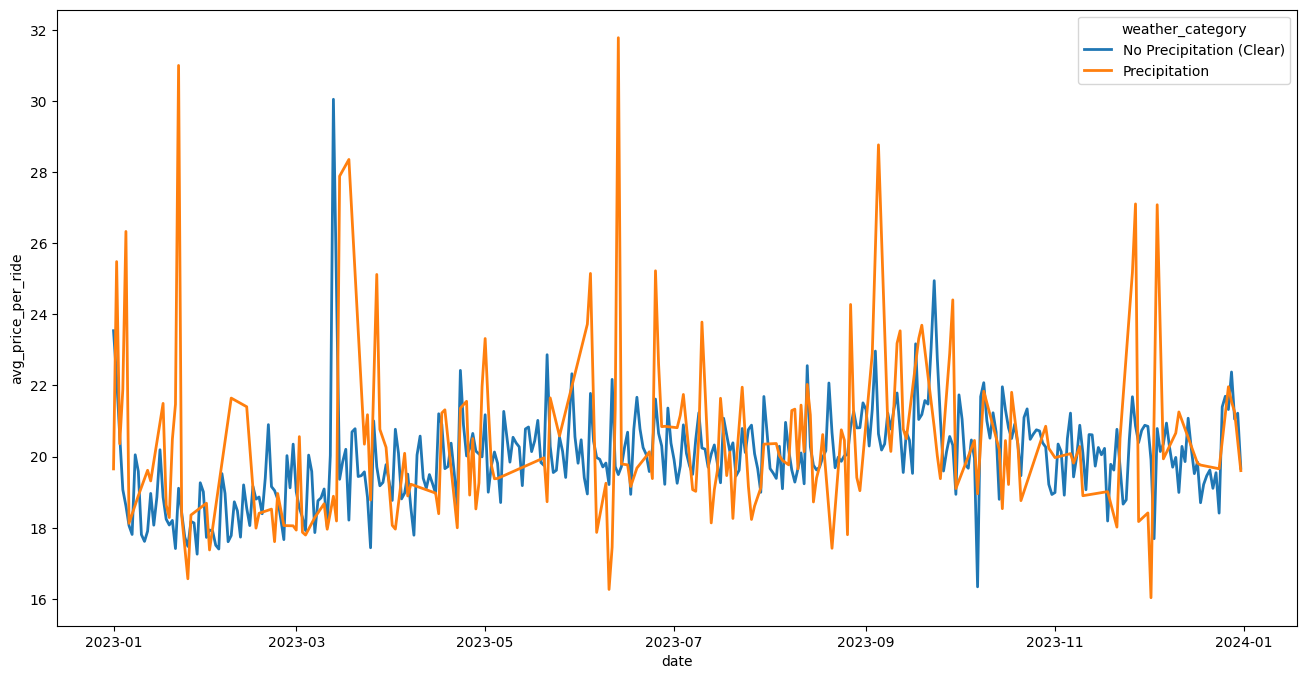

In [13]:
lineplot(
    x='date',
    y='avg_price_per_ride',
    title='Daily Average Price Per Ride by Weather Condition',
    xlabel='Date',
    ylabel='Average Price Per Ride ($)',
    use_seaborn=True,
    data=avg_price_per_ride,
    hue='weather_category',
)

**Insights:**
1. **Higher Variability During Precipitation:**
   - The data shows significant variability in the average price per ride on precipitation days, which could indeed depend on the intensity of rainfall. Heavy rain can increase traffic congestion and trip durations, contributing to spikes in ride costs.

2. **Increase in Average Prices During Rain:**
   - On average, rides during precipitation tend to cost more than on clear days. This is likely a result of factors such as longer travel times, higher demand for ride services.
   - Heavy rain often results in slower traffic speeds and longer trip durations, which directly impacts ride costs, especially for distance or time-based fare structures.

### Temperature Analysis

Understanding the relationship between temperature and ride behavior can provide insights into seasonal trends and customer demand.
This section categorizes temperature into three ranges—`Cold (<0)`, `Moderate (0–15)`, and `Warm (≥15)`—to explore its impact on ride frequency and average ride prices. 

We aggregate data by temperature category to evaluate trends in:
1. Average price per ride across days.
2. Ride frequency normalized by hours.
3. The interplay between weather conditions and temperature variations.

In [14]:
def temperature_categories(temperature):
    """
    Categorizes temperature values into defined ranges.

    Parameters:
    -----------
    temperature : array
        An array or series of temperature values (in °C) to be categorized.

    Returns:
    --------
    array
        A series or array with temperature categories:
        - 'Cold (<0)' for temperatures below 0°C.
        - 'Moderate (0-15)' for temperatures between 0°C and 15°C.
        - 'Warm (>=15)' for temperatures 15°C and above.
    """
    conditions = [(temperature < 0),
                  (temperature >= 0) & (temperature < 15),
                  (temperature >= 15)]
    choices = ['Cold (<0)', 'Moderate (0–15)', 'Warm (>=15)']
    return np.select(conditions, choices, default='Unknown')

merged_data['temperature_cat'] = temperature_categories(merged_data['temperature_2m (°C)'])


### Average Fare Per Ride Analysis
Assesing the relationship between temperature and ride fares. This allows us to compare fare trends across temperature ranges and detect patterns driven by weather and seasonality.

In [15]:
# Group by date, temperature category, and hour to calculate total rides and fare
avg_price_by_temp_hour = merged_data.groupby(['date', 'temperature_cat']).agg({
    'fare_amount': 'sum',       # Total fare for the group
    'tpep_pickup_datetime': 'count'  # Total rides for the day
}).reset_index()

# Calculate average price per ride
avg_price_by_temp_hour['avg_price_per_ride'] = avg_price_by_temp_hour['fare_amount'] / avg_price_by_temp_hour['tpep_pickup_datetime']

print(avg_price_by_temp_hour.head())

         date  temperature_cat  fare_amount  tpep_pickup_datetime  \
0  2023-01-01  Moderate (0–15)    507525.86                 22761   
1  2023-01-02  Moderate (0–15)    434398.61                 19438   
2  2023-01-03  Moderate (0–15)    518309.60                 25298   
3  2023-01-04  Moderate (0–15)    364381.29                 18435   
4  2023-01-04      Warm (>=15)    186314.42                 10039   

   avg_price_per_ride  
0           22.298048  
1           22.347907  
2           20.488165  
3           19.765733  
4           18.559062  


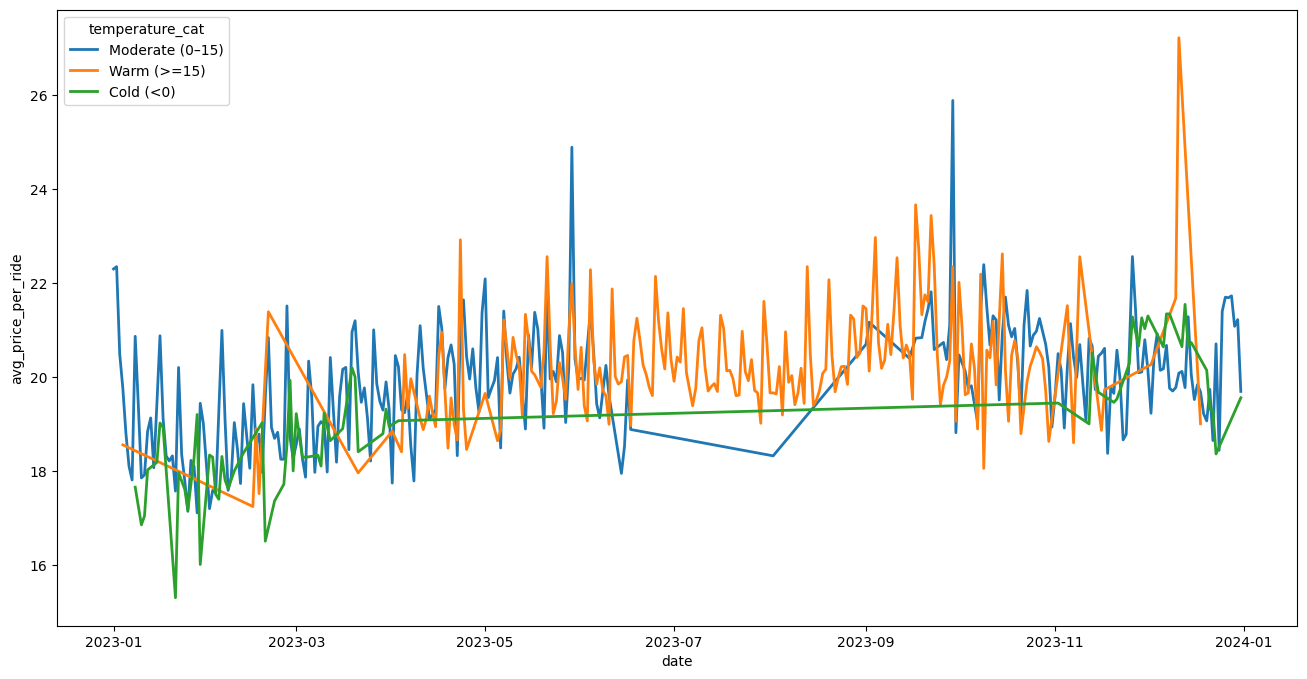

In [16]:
lineplot(
    x='date',
    y='avg_price_per_ride',
    title='Daily Average Price Per Ride by Temperature Condition',
    xlabel='Date',
    ylabel='Average Price Per Ride ($)',
    use_seaborn=True,
    data=avg_price_by_temp_hour,
    hue='temperature_cat',
)

### Insights: Weekly and Temperature Variability

1. **Temperature and Fare Relationship**:
   - Variations in average ride prices across temperature categories (cold, moderate, warm) are visible but relatively minor. This suggests that temperature alone is not the dominant factor influencing fare variability.

2. **Impact of Weekly Patterns**:
   - Weekly trends, such as differences between weekdays and weekends, show a stronger influence on fare prices

3. **Consistency in Cold Weather**:
   - The cold temperature category (<0°C) displays relatively consistent pricing across the time period, indicating a more stable ride behavior or fewer outlier events during colder conditions.


## Rides Per Hour Analysis by Temperature Categories

We aim to calculate the average number of rides per hour for each day and temperature category. This allows us to normalize the ride frequency by the number of weather hours in each day, enabling fair comparisons across varying daily conditions.


In [17]:
# Group by date, weather condition, and temperature category
daily_temperature = merged_data.groupby(['date', 'temperature_cat']).agg({
    'tpep_pickup_datetime': 'count',  # Total ride count
    'time': 'nunique'  # Number of weather hours in a day
}).reset_index()

# Ensure the date column is in datetime format
daily_temperature['date'] = pd.to_datetime(daily_temperature['date'])

# Calculate rides per hour
daily_temperature['rides_per_hour'] = daily_temperature['tpep_pickup_datetime'] / daily_temperature['time']

# Check the resulting data
print(daily_temperature.head())

        date  temperature_cat  tpep_pickup_datetime  time  rides_per_hour
0 2023-01-01  Moderate (0–15)                 22761    24      948.375000
1 2023-01-02  Moderate (0–15)                 19438    24      809.916667
2 2023-01-03  Moderate (0–15)                 25298    24     1054.083333
3 2023-01-04  Moderate (0–15)                 18435    19      970.263158
4 2023-01-04      Warm (>=15)                 10039     5     2007.800000


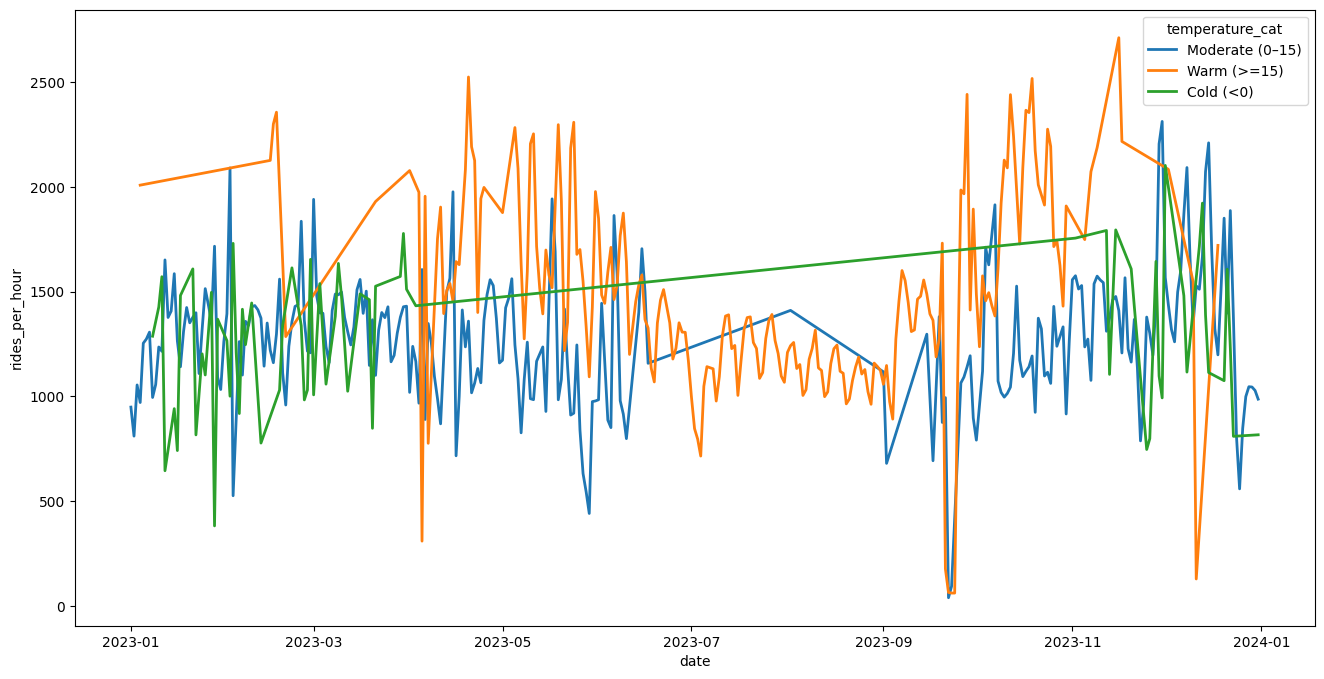

In [18]:
lineplot(
    x='date',
    y='rides_per_hour',
    title='Daily Rides Per Hour by Weather Condition and Temperature Category',
    xlabel='Date',
    ylabel='Rides Per Hour',
    use_seaborn=True,
    data=daily_temperature,
    hue='temperature_cat',
)

### Insights: Daily Rides Per Hour by Temperature Categories

1. **Interplay Between Temperature and Ride Demand**
   - Variations in ride demand across temperature categories suggest that **temperature alone is not the dominant factor**. Instead, other external factors like day of the week, precipitation, or specific events may exert a stronger influence.

3. **Further Analysis with Precipitation**
   - While temperature categories provide valuable insight, combining this data with **precipitation categories or time-of-day splits** could reveal a more granular understanding of the factors influencing rides per hour.

In [19]:
# Group by date, weather condition, and temperature category
daily_weather_temp = merged_data.groupby(['date', 'weather_category', 'temperature_cat']).agg({
    'tpep_pickup_datetime': 'count',  # Total ride count
    'time': 'nunique'  # Number of weather hours in a day
}).reset_index()

# Ensure the date column is in datetime format
daily_weather_temp['date'] = pd.to_datetime(daily_weather_temp['date'])

# Calculate rides per hour
daily_weather_temp['rides_per_hour'] = daily_weather_temp['tpep_pickup_datetime'] / daily_weather_temp['time']

# Check the resulting data
print(daily_weather_temp.head())

        date          weather_category  temperature_cat  tpep_pickup_datetime  \
0 2023-01-01  No Precipitation (Clear)  Moderate (0–15)                 15485   
1 2023-01-01             Precipitation  Moderate (0–15)                  7276   
2 2023-01-02  No Precipitation (Clear)  Moderate (0–15)                 18628   
3 2023-01-02             Precipitation  Moderate (0–15)                   810   
4 2023-01-03  No Precipitation (Clear)  Moderate (0–15)                 13914   

   time  rides_per_hour  
0    17      910.882353  
1     7     1039.428571  
2    23      809.913043  
3     1      810.000000  
4    15      927.600000  


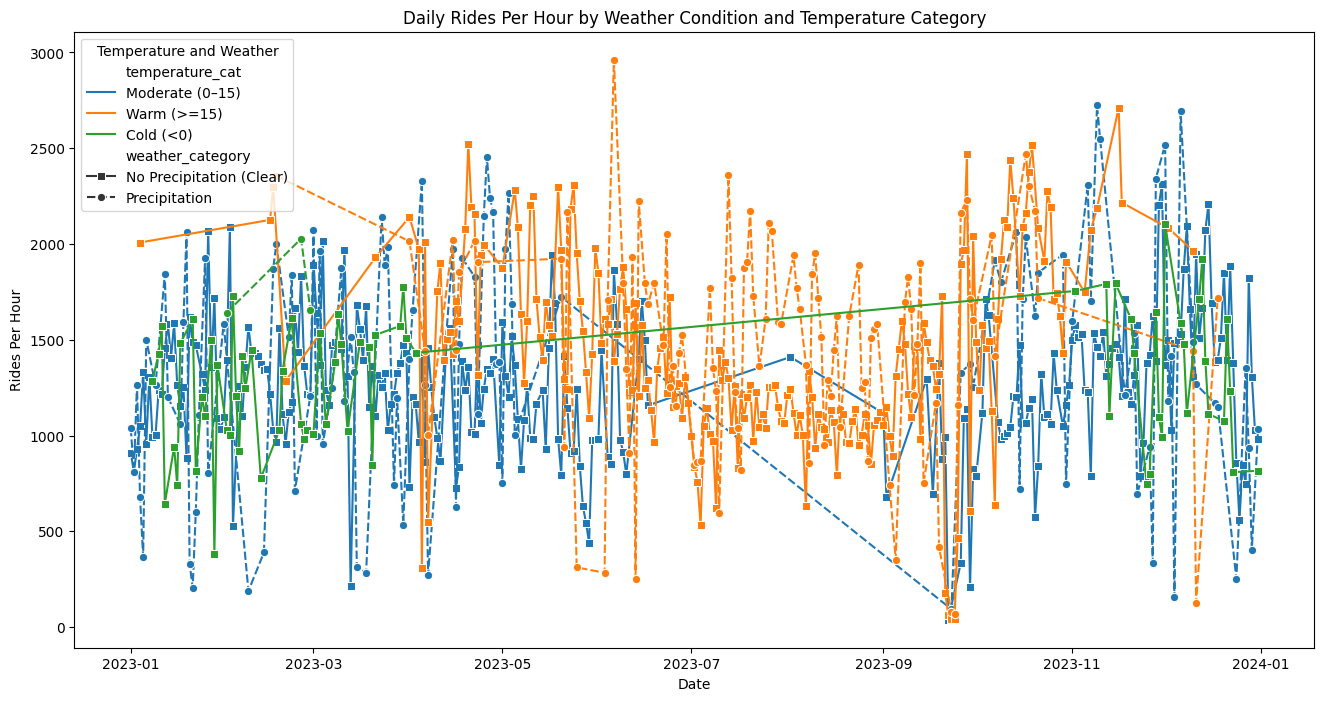

In [20]:
plt.figure(figsize=(16, 8))
sns.lineplot(
    data=daily_weather_temp,
    x='date',
    y='rides_per_hour',
    hue='temperature_cat',
    style='weather_category',
    markers={'Precipitation': 'o', 'No Precipitation (Clear)': 's'}
)
plt.xlabel('Date')
plt.ylabel('Rides Per Hour')
plt.title('Daily Rides Per Hour by Weather Condition and Temperature Category')
plt.legend(title='Temperature and Weather')
plt.show()


**Insights:**

1. **Moderate Temperatures:**
   - Rides per hour in moderate temperatures (`0–15°C`) exhibit the most **variability**, particularly when precipitation is present (`dash-circle line`).
   - This suggests that the **weather category (precipitation vs. clear)** plays a stronger role in influencing variability during this temperature range.

2. **Cold Temperatures:**
   - Cold weather (`<0°C`) shows **consistent and stable trends**, with limited variability across both precipitation and non-precipitation conditions.
   - This likely indicates necessity-driven rides, where weather conditions have less impact on overall demand.

3. **Warm Temperatures:**
   - Warm temperatures (`>=15°C`) are generally more **stable** during clear conditions (`solid line`), with lower ride volumes.
   - However, when precipitation occurs in warm temperatures, the variability **increases significantly**, possibly due to a surge in short-distance or necessity-driven rides to avoid rain.

4. **Impact of Weather Category:**
   - Across all temperature categories, the **presence of precipitation (dash-circle line)** tends to amplify variability in rides per hour, suggesting that rain significantly impacts ride patterns, especially in moderate and warm conditions.

### **Key Takeaways:**
- **Weather (precipitation vs. clear) and temperature interact to influence variability.**
- Precipitation during moderate and warm temperatures drives higher ride demand and variability.
- Cold temperatures remain stable regardless of precipitation.